In [1]:
cd ../analysis/

/home/jlee782/hcomp_paper_seg/analysis


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
from withClustAnalysis import *
from hcomp_paper_viz import *

Populating the interactive namespace from numpy and matplotlib


/home/jlee782/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
from qualityBaseline import compute_self_BBvals
print "generate baseline comparisons"
compute_self_BBvals(compute_metrics=['simple','area']) #run once
retreival_df = compute_best_average_heuristics_workers_baselines(rerun_existing=True) #run once

generate baseline comparisons


/home/jlee782/.local/lib/python2.7/site-packages/pandas/io/parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
  ParserWarning)


# Retreival based heuristic models

-  if we only pick from the best cluster, if no clustering done then retain the same worker performance as before

In [4]:
from baseline import compute_worker_qualities_against_real_performance

In [37]:
obj_clusters = clusters()

In [6]:
clust_df = pd.read_csv("spectral_clustering_all_hard_obj.csv")
noClust_obj =[obj for obj in object_lst if obj not in clust_df.objid.unique() ]
clustObj = clust_df.objid.unique()

In [32]:
retreival_df= pd.read_csv("pixel_em/individual_worker_performance.csv")
retreival_df["sample_num"]=retreival_df.apply(lambda x:int(x["sample"].split("rand")[-1]),axis=1)
no_cluster_retreival_df = retreival_df[retreival_df["clust"]==-1]
cluster_retreival_df = retreival_df[((retreival_df["clust"]!=-1) & (retreival_df["objid"].isin(clustObj)))|((retreival_df["clust"]==-1) & (~retreival_df["objid"].isin(clustObj)))]

In [33]:
#BAD!
# best_clust_df = compute_best_worker_picking()
# cluster_retreival_df=filter_best_clust(retreival_df,best_clust_df)

In [46]:
def best_cluster(x):
    try:
        return obj_clusters[x["sample"]][str(x["objid"])]
    except(KeyError): #non clustered cases
        return -1

retreival_df["best_clust"]=retreival_df.apply(lambda x: best_cluster(x),axis=1)
cluster_retreival_df = retreival_df[retreival_df["best_clust"]==retreival_df["clust"]]
assert len(cluster_retreival_df.groupby(["sample","objid"]).count())==46*31

In [47]:
algoMap={
    'NumPt':'orange',
    'AreaRatio':'green',
    'AvrgWorker':'blue',
    'BestWorker':'red'
}

In [48]:
def worker_scaling_ratio(performance):
    return (performance[-1]-performance[0])/performance[0]

For vision, we scan a variety of inclusion thresholds as well as different levels of segmentation granularities. For each object, we pick parameter that yields the best performing Jaccard.

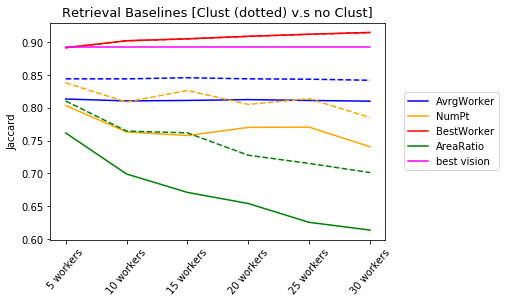

In [49]:
vision = pd.read_csv("pixel_em/vision_only_performance.csv")

NworkerPerformance = no_cluster_retreival_df.groupby("num_workers").mean()
for algo in algoMap.keys():
    algoJ = "J [{}]".format(algo)
    plt.plot(np.array(NworkerPerformance[algoJ]),label=algo,color=algoMap[algo])

NworkerPerformance = cluster_retreival_df.groupby("num_workers").mean()
for algo in  algoMap.keys():
    algoJ = "J [{}]".format(algo)
    plt.plot(np.array(NworkerPerformance[algoJ]),linestyle='--',color=algoMap[algo])

max_vision_k_thresh = vision.loc[vision.groupby(["objid"])['j'].idxmax()].mean()["j"]
y = np.ones_like(np.array(NworkerPerformance[algoJ]))
# vision_performance = vision.groupby(["thresh","k"],as_index=False)[['p', 'r', 'j', 'fpr', 'fnr']].mean()
plt.plot(y*max_vision_k_thresh,label="best vision",color="magenta")
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Retrieval Baselines [Clust (dotted) v.s no Clust]",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])

In [51]:
for algo in  algoMap.keys():
    algoJ = "J [{}]".format(algo)
    performance = np.array(NworkerPerformance[algoJ])
    algoJ,worker_scaling_ratio(performance)

('J [AreaRatio]', -0.13450253999678632)

- add MV in this plot 
- leave out clustering for this 

# Comparing MV with EM ; clust v.s. no clust

In [282]:
df =  compile_all_algo_PRJs()
best_df =  compile_all_algo_PRJs(filter_best=True)

In [694]:
algoMap = {
    'GTLSA':'orange',
    "basic":'green',
    "GT":'blue',
    "isoGT":'red',
    "isoGTLSA": 'cyan',
    "isobasic": 'magenta',
    "MV":"black"
}

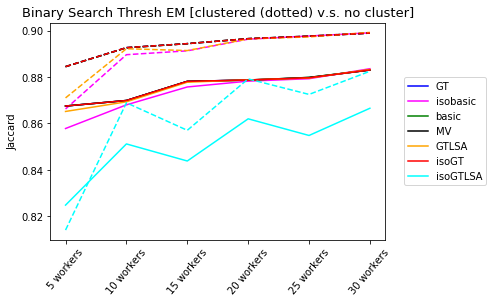

In [698]:
for algo in algoMap.keys():
    # we only ran on the best clusters, so the results should only be on the best clusters if not -1
    x,algo_noclust,algo_clust=clust_vs_noclust(algo,filtered=False)
    plt.plot(algo_noclust,label=algo,color = algoMap[algo])
    plt.plot(algo_clust,linestyle="--",color = algoMap[algo])
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Binary Search Thresh EM [clustered (dotted) v.s. no cluster]",fontsize=13)

basic, isoGT and GT are all very close to MV

In [667]:
def avrg_percent_change(clust,noClust):
    return "{:.3f}%".format(np.mean(np.array(clust)-np.array(noClust))*100)

__Comparing cluster v.s. no cluster__

In [704]:
m2m = {"precision":'p','recall':'r', 'jaccard':'j', u'FNR%':'fnr','FPR%':'fpr'}
for metric in ['precision', u'recall', u'jaccard', u'FNR%','FPR%']:
    print "------------"
    print "percent change due to clustering for metric:",metric
    x,MV_noclust,MV_clust=clust_vs_noclust('MV',metric=metric,filtered=False)
    print "{} :{}".format("MV",avrg_percent_change(MV_clust,MV_noclust))
    for algo in algoMap.keys():
        x,algo_noclust,algo_clust=clust_vs_noclust(algo,metric=metric,filtered=False)
        print "{} :{}".format(algo,avrg_percent_change(algo_clust,algo_noclust))

------------
percent change due to clustering for metric: precision
MV :0.346%
GT :0.349%
isobasic :0.322%
basic :0.352%
MV :0.346%
GTLSA :0.190%
isoGT :0.349%
isoGTLSA :-0.291%
------------
percent change due to clustering for metric: recall
MV :1.548%
GT :1.550%
isobasic :1.575%
basic :1.549%
MV :1.548%
GTLSA :1.310%
isoGT :1.550%
isoGTLSA :1.620%
------------
percent change due to clustering for metric: jaccard
MV :1.793%
GT :1.795%
isobasic :1.627%
basic :1.796%
MV :1.793%
GTLSA :1.564%
isoGT :1.795%
isoGTLSA :1.185%
------------
percent change due to clustering for metric: FNR%
MV :-154.848%
GT :-154.990%
isobasic :-157.462%
basic :-154.875%
MV :-154.848%
GTLSA :-131.022%
isoGT :-154.990%
isoGTLSA :-162.014%
------------
percent change due to clustering for metric: FPR%
MV :-2.218%
GT :-2.240%
isobasic :4.031%
basic :-2.260%
MV :-2.218%
GTLSA :-2.299%
isoGT :-2.240%
isoGTLSA :78.406%


__Comparing cluster (best) v.s. MV__

In [707]:
m2m = {"precision":'p','recall':'r', 'jaccard':'j', u'FNR%':'fnr','FPR%':'fpr'}
for metric in ['precision', u'recall', u'jaccard', u'FNR%','FPR%']:
    print "------------"
    print "percent change compared to MV for metric:",metric
    x,MV_noclust,MV_clust=clust_vs_noclust('MV',metric=metric,filtered=False)
    for algo in algoMap.keys():
        x,algo_noclust,algo_clust=clust_vs_noclust(algo,metric=metric,filtered=False)
        print "{} :{}".format(algo,avrg_percent_change(algo_clust,MV_clust))

------------
percent change compared to MV for metric: precision
GT :0.000%
isobasic :-0.390%
basic :0.001%
MV :0.000%
GTLSA :-0.200%
isoGT :0.000%
isoGTLSA :-3.425%
------------
percent change compared to MV for metric: recall
GT :0.001%
isobasic :-0.050%
basic :0.000%
MV :0.000%
GTLSA :-0.270%
isoGT :0.001%
isoGTLSA :-0.598%
------------
percent change compared to MV for metric: jaccard
GT :0.001%
isobasic :-0.406%
basic :0.001%
MV :0.000%
GTLSA :-0.283%
isoGT :0.001%
isoGTLSA :-3.176%
------------
percent change compared to MV for metric: FNR%
GT :-0.051%
isobasic :4.960%
basic :-0.011%
MV :0.000%
GTLSA :26.969%
isoGT :-0.051%
isoGTLSA :59.800%
------------
percent change compared to MV for metric: FPR%
GT :-0.004%
isobasic :37.214%
basic :-0.020%
MV :0.000%
GTLSA :0.187%
isoGT :-0.004%
isoGTLSA :301.185%


# Greedy Results

In [846]:
greedy_df = pd.read_csv("all_greedy_result.csv")
greedy_df["num_workers"]=greedy_df.apply(lambda x:int(x["sample"].split("workers")[0]),axis=1)
greedy_df["sample_num"] = greedy_df.apply(lambda x: int(x["sample"].split("rand")[-1]),axis=1)
greedy_noclust=greedy_df[greedy_df["clust"]==-1]
greedy_clust= filter_best_clust(greedy_df,best_clust_df)
assert greedy_noclust.groupby(["sample"])["objid"].count().unique()[0]==8*46

In [847]:
algoMap = {
    'GTLSA':'orange',
    "basic":'green',
    "GT":'blue',
    "isoGT":'red',
    "isoGTLSA": 'cyan',
    "isobasic": 'magenta',
    "worker_fraction": 'pink',
    "ground_truth": 'yellow'
}

In [848]:
from analyze_prjs import clust_vs_noclust

(0.82, 0.99)

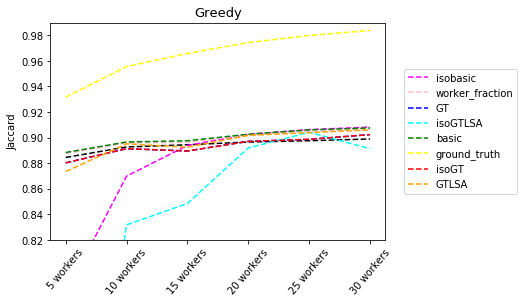

In [853]:
x,MV_noclust,MV_clust=clust_vs_noclust('MV',filtered=False)

# plt.plot(MV_noclust,label="MV",color="black")
plt.plot(MV_clust,color="black",linestyle="--")

for algo in algoMap.keys():
    algo_noClust = np.array(greedy_noclust[greedy_noclust["algo"]==algo].groupby(["num_workers"]).mean()["j"])
    algo_clust = np.array(greedy_clust[greedy_clust["algo"]==algo].groupby(["num_workers"]).mean()["j"])
#     plt.plot(algo_noClust,label=algo,color=algoMap[algo])
    plt.plot(algo_clust,color=algoMap[algo],label=algo,linestyle='--')
    
    
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Greedy",fontsize=13)
plt.ylim(0.82,0.99)

In [714]:
m2m = {"precision":'p','recall':'r', 'jaccard':'j', u'FNR%':'fnr','FPR%':'fpr'}
for metric in ['precision', u'recall', u'jaccard', u'FNR%','FPR%']:
    print "------------"
    print "percent change due to clustering for metric:",metric
    x,MV_noclust,MV_clust=clust_vs_noclust('MV',metric=metric,filtered=False)
    print "{} :{}".format("MV",avrg_percent_change(MV_clust,MV_noclust))
    for algo in algoMap.keys():
        algo_noClust = np.array(greedy_noclust[greedy_noclust["algo"]==algo].groupby(["num_workers"]).mean()[m2m[metric]])
        algo_clust = np.array(greedy_clust[greedy_clust["algo"]==algo].groupby(["num_workers"]).mean()[m2m[metric]])
        print "{} :{}".format(algo,avrg_percent_change(algo_clust,algo_noClust))

------------
percent change due to clustering for metric: precision
MV :0.346%
isobasic :-1.559%
worker_fraction :4.305%
GT :1.347%
isoGTLSA :-0.700%
basic :0.671%
ground_truth :-0.067%
isoGT :1.347%
GTLSA :1.293%
------------
percent change due to clustering for metric: recall
MV :1.548%
isobasic :1.688%
worker_fraction :0.459%
GT :0.878%
isoGTLSA :1.754%
basic :1.791%
ground_truth :0.011%
isoGT :0.878%
GTLSA :0.998%
------------
percent change due to clustering for metric: jaccard
MV :1.793%
isobasic :0.144%
worker_fraction :4.726%
GT :2.074%
isoGTLSA :0.337%
basic :2.234%
ground_truth :-0.055%
isoGT :2.074%
GTLSA :2.310%
------------
percent change due to clustering for metric: FNR%
MV :-154.848%
isobasic :-168.833%
worker_fraction :-45.861%
GT :-87.821%
isoGTLSA :-175.434%
basic :-179.058%
ground_truth :-1.107%
isoGT :-87.821%
GTLSA :-99.755%
------------
percent change due to clustering for metric: FPR%
MV :-2.218%
isobasic :246.690%
worker_fraction :-76.180%
GT :-5.645%
isoGTLSA 

In [716]:
m2m = {"precision":'p','recall':'r', 'jaccard':'j', u'FNR%':'fnr','FPR%':'fpr'}
for metric in ['precision', u'recall', u'jaccard', u'FNR%','FPR%']:
    print "------------"
    print "percent change compared to MV for metric:",metric
    x,MV_noclust,MV_clust=clust_vs_noclust('MV',metric=metric,filtered=False)
    for algo in algoMap.keys():
        algo_noClust = np.array(greedy_noclust[greedy_noclust["algo"]==algo].groupby(["num_workers"]).mean()[m2m[metric]])
        algo_clust = np.array(greedy_clust[greedy_clust["algo"]==algo].groupby(["num_workers"]).mean()[m2m[metric]])
        print "{} :{}".format(algo,avrg_percent_change(algo_clust,MV_clust))

------------
percent change compared to MV for metric: precision
isobasic :-2.174%
worker_fraction :-0.257%
GT :-2.003%
isoGTLSA :-9.181%
basic :0.266%
ground_truth :3.757%
isoGT :-2.003%
GTLSA :-0.098%
------------
percent change compared to MV for metric: recall
isobasic :0.186%
worker_fraction :0.848%
GT :2.092%
isoGTLSA :0.680%
basic :0.405%
ground_truth :3.931%
isoGT :2.092%
GTLSA :0.129%
------------
percent change compared to MV for metric: jaccard
isobasic :-1.766%
worker_fraction :0.469%
GT :-0.090%
isoGTLSA :-8.360%
basic :0.568%
ground_truth :7.104%
isoGT :-0.090%
GTLSA :0.135%
------------
percent change compared to MV for metric: FNR%
isobasic :-18.628%
worker_fraction :-84.831%
GT :-209.229%
isoGTLSA :-67.981%
basic :-40.540%
ground_truth :-393.135%
isoGT :-209.229%
GTLSA :-12.948%
------------
percent change compared to MV for metric: FPR%
isobasic :271.687%
worker_fraction :2.427%
GT :7.377%
isoGTLSA :1023.155%
basic :0.572%
ground_truth :-10.860%
isoGT :7.377%
GTLSA :1

In [709]:
algo = "ground_truth"
algo_noClust = np.array(greedy_noclust[greedy_noclust["algo"]==algo].groupby(["num_workers"]).mean()["j"])
algo_clust = np.array(greedy_clust[greedy_clust["algo"]==algo].groupby(["num_workers"]).mean()["j"])

print "When using ground truth to estimate intersection areas, we can achieve a Jaccard of {:.3f}".format(algo_noClust[-1]) ," as an upper bound with 30 workers, which indicates that with better probablistic estimation of intersection area, aggregation-based methods can achieve close to perfect estimation, exceeding the results of any single `best' worker."

When using ground truth to estimate intersection areas, we can achieve a Jaccard of 0.983  as an upper bound with 30 workers, which indicates that with better probablistic estimation of intersection area, aggregation-based methods can achieve close to perfect estimation, exceeding the results of any single `best' worker.


# Relationship between actual number of workers and how much in the cluster is actually ran

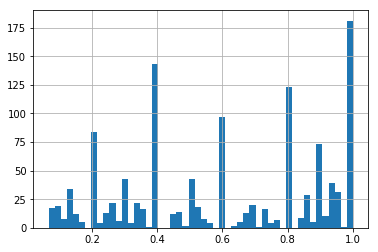

In [717]:
df["ratio_Nworker"]=df["actualNworkers"]/df["num_workers"]

# df["ratio_Nworker"].hist()
df[df["clust"]!=-1]["ratio_Nworker"].hist(bins=50)

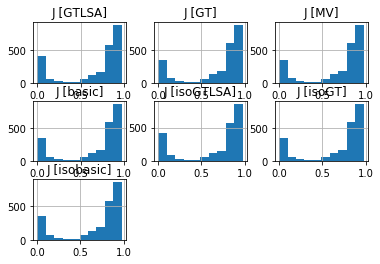

In [718]:
a = df_withClust[metric_J].hist()

# Correlation of worker quality with individual worker performance

In [949]:
object_lst = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40,41,42, 43, 44, 45, 46, 47]

In [617]:
qj_df=compute_worker_qualities_against_real_performance()#run once

In [618]:
qj_df = pd.read_csv("EM_worker_qualities_against_real_performance.csv",index_col=0)
qj_df["num_workers"] = qj_df.apply(lambda x: int(x["sample"].split("workers")[0]),axis=1)

In [645]:
from scipy.stats import linregress
def corr_calc(selected_df):
    x = np.array(selected_df["qj"])
    y = np.array(selected_df["Jaccard [Self]"])
    linresult = linregress(x,y)
    return linresult.rvalue,linresult.pvalue

In [745]:
from sklearn import linear_model
def compute_multi_regression(selected_df,x_fields,yfields=["Precision [Self]","Recall [Self]","Jaccard [Self]"]):
    x = np.array(selected_df[x_fields])
    y = np.array(selected_df[yfields])
    # Initialize model
    regression_model = linear_model.LinearRegression()
    regression_model.fit(X = x, y = y)
    #print(regression_model.coef_)
    return regression_model.score(x,y)

GTLSA does poorly because qn1 not a very good estimator, if we look at the coefficients of qn1.

#### Linear regression with y=[P,R,J] , with clustering 

In [819]:
obj_clusters = clusters()
df_data = []
for sample_name in tqdm(sample_lst):
    for objid in object_lst:
        if str(objid) in obj_clusters[sample_name]:
            clusts = [obj_clusters[sample_name][str(objid)]]
        else:
            clusts = ["-1"]
        for cluster_id in clusts:
            worker_ids = np.array(clust_df[(clust_df["objid"] == objid) & (clust_df["cluster"] == int(cluster_id))].wid)
            if len(worker_ids) > 1 or cluster_id == "-1":
#                 if cluster_id!="" and cluster_id!="-1"  :
#                     outdir = '{}{}/obj{}/clust{}/'.format(PIXEL_EM_DIR, sample_name, objid,cluster_id)
#                 else:
#                     outdir = '{}{}/obj{}/'.format(PIXEL_EM_DIR, sample_name, objid)
                selected_df = qj_df[(qj_df["sample"]==sample_name)&(qj_df["objid"]==objid)&(qj_df["clust"]==int(cluster_id))]
                if len(selected_df)>1: #only best clusters were ran, so ignore ones where no qj-df (non best clusters) was computed
                    #r,p = corr_calc(selected_df)
                    basic_R2 = compute_multi_regression(selected_df,["qj"])
                    GT_R2 = compute_multi_regression(selected_df,["qn","qp"])
                    GTLSA_R2 =compute_multi_regression(selected_df,["qn1","qp1","qn2","qp2"])
                    ibasic_R2 = compute_multi_regression(selected_df,["iqj"])
                    iGT_R2 = compute_multi_regression(selected_df,["iqn","iqp"])
                    iGTLSA_R2 =compute_multi_regression(selected_df,["iqn1","iqp1","iqn2","iqp2"])
                    df_data.append([sample_name,objid,cluster_id,basic_R2,GT_R2,GTLSA_R2,ibasic_R2,iGT_R2,iGTLSA_R2])

In [820]:
qj_fit = pd.DataFrame(df_data,columns=["sample","objid","clust","basic_R2","GT_R2","GTLSA_R2","ibasic_R2","iGT_R2","iGTLSA_R2"])
qj_fit["num_workers"]=qj_fit["sample"].apply(lambda x: int(x.split("workers")[0]))
qj_fit.groupby("num_workers",as_index=False).mean()[["num_workers",'basic_R2', u'GT_R2', u'GTLSA_R2','ibasic_R2', u'iGT_R2', u'iGTLSA_R2']]

,num_workers,basic_R2,GT_R2,GTLSA_R2,ibasic_R2,iGT_R2,iGTLSA_R2
0,5,0.571566,0.899148,0.893688,0.544765,0.899148,0.895786
1,10,0.566494,0.879678,0.885713,0.560214,0.879678,0.886416
2,15,0.537012,0.877725,0.877340,0.532138,0.877725,0.877035
3,20,0.579212,0.879618,0.884407,0.577321,0.879618,0.883996
4,25,0.574618,0.876229,0.884376,0.577181,0.876229,0.883989
5,30,0.588299,0.887214,0.894863,0.588734,0.887214,0.893949


correlation score is actually lower than in the clustering case, this means: 

       1) worker quality actually predicts p,r,j well in the no clustering case
       2) could also be because the actual N workers is smaller than the reported num_workers in sample, so don't fit as well

#### Linear regression with y=[P,R,J] , no clustering 

In [805]:
qj_df_no_clust = qj_df[qj_df["clust"]==-1]
df_data = []
for sample_name in tqdm(sample_lst):
    for objid in object_lst:
        cluster_ids = clust_df[(clust_df["objid"] == objid)].cluster.unique()
        for cluster_id in ["-1"] + list(cluster_ids):
            worker_ids = np.array(clust_df[(clust_df["objid"] == objid) & (clust_df["cluster"] == int(cluster_id))].wid)
            if len(worker_ids) > 1 or cluster_id == "-1":
#                 if cluster_id!="" and cluster_id!="-1"  :
#                     outdir = '{}{}/obj{}/clust{}/'.format(PIXEL_EM_DIR, sample_name, objid,cluster_id)
#                 else:
#                     outdir = '{}{}/obj{}/'.format(PIXEL_EM_DIR, sample_name, objid)
                selected_df = qj_df_no_clust[(qj_df_no_clust["sample"]==sample_name)&(qj_df_no_clust["objid"]==objid)&(qj_df_no_clust["clust"]==int(cluster_id))]
                if len(selected_df)>1: #only best clusters were ran, so ignore ones where no qj-df (non best clusters) was computed
                    #r,p = corr_calc(selected_df)
                    basic_R2 = compute_multi_regression(selected_df,["qj"])
                    GT_R2 = compute_multi_regression(selected_df,["qn","qp"])
                    GTLSA_R2 =compute_multi_regression(selected_df,["qn1","qp1","qn2","qp2"])
                    ibasic_R2 = compute_multi_regression(selected_df,["iqj"])
                    iGT_R2 = compute_multi_regression(selected_df,["iqn","iqp"])
                    iGTLSA_R2 =compute_multi_regression(selected_df,["iqn1","iqp1","iqn2","iqp2"])
                    df_data.append([sample_name,objid,cluster_id,basic_R2,GT_R2,GTLSA_R2,ibasic_R2,iGT_R2,iGTLSA_R2])

In [806]:
qj_fit = pd.DataFrame(df_data,columns=["sample","objid","clust","basic_R2","GT_R2","GTLSA_R2","ibasic_R2","iGT_R2","iGTLSA_R2"])
qj_fit["num_workers"]=qj_fit["sample"].apply(lambda x: int(x.split("workers")[0]))
qj_fit.groupby("num_workers",as_index=False).mean()[["num_workers",'basic_R2', u'GT_R2', u'GTLSA_R2','ibasic_R2', u'iGT_R2', u'iGTLSA_R2']]

,num_workers,basic_R2,GT_R2,GTLSA_R2,ibasic_R2,iGT_R2,iGTLSA_R2
0,5,0.593570,0.904936,0.899432,0.568433,0.904936,0.902699
1,10,0.621300,0.894471,0.898339,0.623168,0.894471,0.898129
2,15,0.613587,0.897573,0.898160,0.612421,0.897573,0.897199
3,20,0.627221,0.895251,0.899794,0.628894,0.895251,0.899153
4,25,0.653650,0.902877,0.907879,0.654613,0.902877,0.906851
5,30,0.665388,0.907131,0.914429,0.668558,0.907131,0.913467


#### Linear regression with y=[P,R,J] , overall 

In [800]:
df_data = []
for sample_name in tqdm(sample_lst):
    for objid in object_lst:
        cluster_ids = clust_df[(clust_df["objid"] == objid)].cluster.unique()
        for cluster_id in ["-1"] + list(cluster_ids):
            worker_ids = np.array(clust_df[(clust_df["objid"] == objid) & (clust_df["cluster"] == int(cluster_id))].wid)
            if len(worker_ids) > 1 or cluster_id == "-1":
#                 if cluster_id!="" and cluster_id!="-1"  :
#                     outdir = '{}{}/obj{}/clust{}/'.format(PIXEL_EM_DIR, sample_name, objid,cluster_id)
#                 else:
#                     outdir = '{}{}/obj{}/'.format(PIXEL_EM_DIR, sample_name, objid)
                selected_df = qj_df[(qj_df["sample"]==sample_name)&(qj_df["objid"]==objid)&(qj_df["clust"]==int(cluster_id))]
                if len(selected_df)>1: #only best clusters were ran, so ignore ones where no qj-df (non best clusters) was computed
                    #r,p = corr_calc(selected_df)
                    basic_R2 = compute_multi_regression(selected_df,["qj"])
                    GT_R2 = compute_multi_regression(selected_df,["qn","qp"])
                    GTLSA_R2 =compute_multi_regression(selected_df,["qn1","qp1","qn2","qp2"])
                    ibasic_R2 = compute_multi_regression(selected_df,["iqj"])
                    iGT_R2 = compute_multi_regression(selected_df,["iqn","iqp"])
                    iGTLSA_R2 =compute_multi_regression(selected_df,["iqn1","iqp1","iqn2","iqp2"])
                    df_data.append([sample_name,objid,cluster_id,basic_R2,GT_R2,GTLSA_R2,ibasic_R2,iGT_R2,iGTLSA_R2])

In [801]:
qj_fit = pd.DataFrame(df_data,columns=["sample","objid","clust","basic_R2","GT_R2","GTLSA_R2","ibasic_R2","iGT_R2","iGTLSA_R2"])
qj_fit["num_workers"]=qj_fit["sample"].apply(lambda x: int(x.split("workers")[0]))
qj_fit.groupby("num_workers",as_index=False).mean()[["num_workers",'basic_R2', u'GT_R2', u'GTLSA_R2','ibasic_R2', u'iGT_R2', u'iGTLSA_R2']]

,num_workers,basic_R2,GT_R2,GTLSA_R2,ibasic_R2,iGT_R2,iGTLSA_R2
0,5,0.625870,0.918168,0.913721,0.602224,0.918168,0.917546
1,10,0.623861,0.901470,0.905803,0.617260,0.901470,0.906440
2,15,0.601570,0.898414,0.899718,0.595583,0.898414,0.899207
3,20,0.624768,0.898738,0.902505,0.625916,0.898738,0.903560
4,25,0.647071,0.902532,0.909456,0.646153,0.902532,0.910195
5,30,0.652715,0.914480,0.921302,0.661211,0.914480,0.920875


#### Linear regression with y=jaccard only

In [802]:
df_data = []
for sample_name in tqdm(sample_lst):
    for objid in object_lst:
        cluster_ids = clust_df[(clust_df["objid"] == objid)].cluster.unique()
        for cluster_id in ["-1"] + list(cluster_ids):
            worker_ids = np.array(clust_df[(clust_df["objid"] == objid) & (clust_df["cluster"] == int(cluster_id))].wid)
            if len(worker_ids) > 1 or cluster_id == "-1":
#                 if cluster_id!="" and cluster_id!="-1"  :
#                     outdir = '{}{}/obj{}/clust{}/'.format(PIXEL_EM_DIR, sample_name, objid,cluster_id)
#                 else:
#                     outdir = '{}{}/obj{}/'.format(PIXEL_EM_DIR, sample_name, objid)
                selected_df = qj_df[(qj_df["sample"]==sample_name)&(qj_df["objid"]==objid)&(qj_df["clust"]==int(cluster_id))]
                if len(selected_df)>1: #only best clusters were ran, so ignore ones where no qj-df (non best clusters) was computed
                    #r,p = corr_calc(selected_df)
                    basic_R2 = compute_multi_regression(selected_df,["qj"],["Jaccard [Self]"])
                    GT_R2 = compute_multi_regression(selected_df,["qn","qp"],["Jaccard [Self]"])
                    GTLSA_R2 =compute_multi_regression(selected_df,["qn1","qp1","qn2","qp2"],["Jaccard [Self]"])
                    ibasic_R2 = compute_multi_regression(selected_df,["iqj"],["Jaccard [Self]"])
                    iGT_R2 = compute_multi_regression(selected_df,["iqn","iqp"],["Jaccard [Self]"])
                    iGTLSA_R2 =compute_multi_regression(selected_df,["iqn1","iqp1","iqn2","iqp2"],["Jaccard [Self]"])
                    df_data.append([sample_name,objid,cluster_id,basic_R2,GT_R2,GTLSA_R2,ibasic_R2,iGT_R2,iGTLSA_R2])

In [795]:
qj_fit = pd.DataFrame(df_data,columns=["sample","objid","clust","basic_R2","GT_R2","GTLSA_R2","ibasic_R2","iGT_R2","iGTLSA_R2"])
qj_fit["num_workers"]=qj_fit["sample"].apply(lambda x: int(x.split("workers")[0]))
qj_fit.groupby("num_workers",as_index=False).mean()[["num_workers",'basic_R2', u'GT_R2', u'GTLSA_R2','ibasic_R2', u'iGT_R2', u'iGTLSA_R2']]

,num_workers,basic_R2,GT_R2,GTLSA_R2,ibasic_R2,iGT_R2,iGTLSA_R2
0,5,0.657601,0.842720,0.835651,0.642493,0.842720,0.842945
1,10,0.684024,0.822323,0.829095,0.688944,0.822323,0.829975
2,15,0.686342,0.815078,0.815910,0.680959,0.815078,0.815230
3,20,0.707594,0.834291,0.838626,0.711541,0.834291,0.839535
4,25,0.740575,0.848744,0.855190,0.740101,0.848744,0.855222
5,30,0.743275,0.859044,0.867620,0.750555,0.859044,0.867135


In [794]:
# qj_fit[qj_fit["clust"]=='-1'].groupby("num_workers").mean()["R"]
# qj_fit[qj_fit["clust"]=='-1'].groupby("num_workers").mean()["p"]
# qj_fit[qj_fit["clust"]=='-1'].groupby("num_workers").mean()["p"]/len(qj_fit) #with Bonferonni correction
#-2*sum(np.log(qj_fit["p"])) #fisher's method normalization

In [796]:
# for objid in object_lst:
#     selected_df = qj_df[(qj_df["sample"]=="30workers_rand0")&(qj_df["objid"]==objid)&(qj_df["clust"]==-1)]
#     plt.figure()
#     plt.title(objid)
#     x = np.array(selected_df["qj"])
#     y = np.array(selected_df["Jaccard [Self]"])
#     linresult = linregress(x,y)
#     plt.plot(x,y,'o')
#     plt.plot(x,linresult.slope*x+linresult.intercept,'-')
#     plt.text(min(x),max(y),"R={:.2f}; p={:.2e}".format(linresult.rvalue,linresult.pvalue))
#     plt.xlabel("Worker quality qj")
#     plt.ylabel("Jaccard")
#     # plt.xlim(0.95,1)

# GT-estimation by picking best worker based on worker quality.

In [854]:
qj_df = pd.read_csv("EM_worker_qualities_against_real_performance.csv",index_col=0)
qj_df["num_workers"] = qj_df.apply(lambda x: int(x["sample"].split("workers")[0]),axis=1)

In [864]:
best_basic_worker=qj_df.loc[qj_df.groupby(["sample","objid"])["qj"].idxmax()]
assert len(best_basic_worker)==31*46

In [865]:
best_basic_worker.groupby("num_workers").mean()["Jaccard [Self]"]

num_workers
5     0.791899
10    0.751593
15    0.756736
20    0.748013
25    0.722146
30    0.777821
Name: Jaccard [Self], dtype: float64

In [868]:
qj_df["GT_qjsum"] = qj_df.apply(lambda x: x["qp"]+x["qn"],axis=1)
best_GT_worker=qj_df.loc[qj_df.groupby(["sample","objid"])["GT_qjsum"].idxmax()]
assert len(best_GT_worker)==31*46
best_GT_worker.groupby("num_workers").mean()["Jaccard [Self]"]

num_workers
5     0.772541
10    0.726270
15    0.716735
20    0.708912
25    0.715807
30    0.750491
Name: Jaccard [Self], dtype: float64

In [870]:
qj_df["GTLSA_qjsum"] = qj_df.apply(lambda x: x["qp1"]+x["qn1"]+x["qn2"]+x["qp1"],axis=1)
best_GTLSA_worker=qj_df.loc[qj_df.groupby(["sample","objid"])["GTLSA_qjsum"].idxmax()]
assert len(best_GTLSA_worker)==31*46
best_GTLSA_worker.groupby("num_workers").mean()["Jaccard [Self]"]

num_workers
5     0.845210
10    0.825366
15    0.808331
20    0.796336
25    0.805057
30    0.803403
Name: Jaccard [Self], dtype: float64

In [961]:
x_fields = ['qj']
y_fields = ['Precision [Self]', 'Recall [Self]', 'Jaccard [Self]']
df_data = []
for sample_name in tqdm(sample_lst):
    for objid in object_lst:
        selected_df =qj_df[qj_df["objid"]==objid]
        x = np.array(selected_df[x_fields])
        y = np.array(selected_df[y_fields])
        regression_model = linear_model.LinearRegression()
        regression_model.fit(X = x, y = y)
        
        cluster_ids = clust_df[(clust_df["objid"] == objid)].cluster.unique()
        for cluster_id in ["-1"] + list(cluster_ids):
            worker_ids = np.array(clust_df[(clust_df["objid"] == objid) & (clust_df["cluster"] == int(cluster_id))].wid)
            if len(worker_ids) > 1 or cluster_id == "-1":
                selected_df = qj_df[(qj_df["sample"]==sample_name)&(qj_df["objid"]==objid)&(qj_df["clust"]==int(cluster_id))]
                if len(selected_df)>1: #only best clusters were ran, so ignore ones where no qj-df (non best clusters) was computed
                    for row in selected_df.iterrows():
                        pred_p,pred_r,pred_j = regression_model.predict(row[1]["qj"])[0]
                        df_data.append([sample_name,objid,row[1]["qj"],cluster_id,pred_p,pred_r,pred_j])                        

In [962]:
qj_predicted = pd.DataFrame(df_data,columns=["sample","objid","qj","clust","p","r","j"])
qj_predicted["num_workers"]=qj_predicted["sample"].apply(lambda x: int(x.split("workers")[0]))

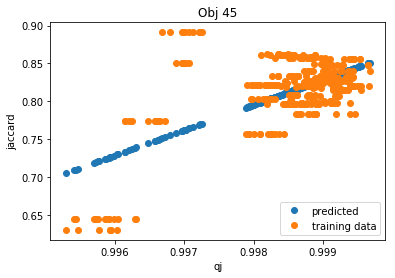

In [930]:
objid=45
selected_df =qj_predicted[qj_predicted["objid"]==objid]
selected_df_orig =qj_df[qj_df["objid"]==objid]
plt.plot(selected_df["qj"],selected_df["j"],'o',label="predicted")
plt.plot(selected_df_orig["qj"],selected_df_orig["Jaccard [Self]"],'o',label="training data")
plt.title("Obj {}".format(objid))
plt.xlabel("qj")
plt.ylabel("jaccard")
plt.legend()

In [963]:
best_qj_predicted = qj_predicted.loc[qj_predicted.groupby(["sample","objid"])["j"].idxmax()]
assert len(best_qj_predicted)==31*46
best_basic_predicted_score = best_qj_predicted.groupby("num_workers").mean()["j"]
best_basic_predicted_score

num_workers
5     0.848179
10    0.850849
15    0.851362
20    0.851667
25    0.852593
30    0.853102
Name: j, dtype: float64

In [1023]:
import warnings
warnings.filterwarnings('ignore')

def predict_prj_linear_regression(qj_df, x_fields,y_fields = ['Precision [Self]', 'Recall [Self]', 'Jaccard [Self]']):
    df_data = []
    for sample_name in tqdm(sample_lst):
        for objid in object_lst:
            selected_df =qj_df[qj_df["objid"]==objid]
            x = np.array(selected_df[x_fields])
            y = np.array(selected_df[y_fields])
            regression_model = linear_model.LinearRegression()
            regression_model.fit(X = x, y = y)

            cluster_ids = clust_df[(clust_df["objid"] == objid)].cluster.unique()
            for cluster_id in ["-1"] + list(cluster_ids):
                worker_ids = np.array(clust_df[(clust_df["objid"] == objid) & (clust_df["cluster"] == int(cluster_id))].wid)
                if len(worker_ids) > 1 or cluster_id == "-1":
                    selected_df = qj_df[(qj_df["sample"]==sample_name)&(qj_df["objid"]==objid)&(qj_df["clust"]==int(cluster_id))]
                    if len(selected_df)>1: #only best clusters were ran, so ignore ones where no qj-df (non best clusters) was computed
                        for row in selected_df.iterrows():
                            pred_p,pred_r,pred_j = regression_model.predict(row[1][x_fields])[0]
                            df_data.append([sample_name,objid, cluster_id,pred_p,pred_r,pred_j])                        

    qj_predicted = pd.DataFrame(df_data,columns=["sample","objid","clust","p","r","j"])
    qj_predicted["num_workers"]=qj_predicted["sample"].apply(lambda x: int(x.split("workers")[0]))
    
    best_qj_predicted = qj_predicted.loc[qj_predicted.groupby(["sample","objid"])["j"].idxmax()]
    try:
        assert len(best_qj_predicted)==31*46
    except(AssertionError):
        print "assertion error:",len(best_qj_predicted)
    best_predicted_score = np.array(best_qj_predicted.groupby("num_workers").mean()["j"])
    return best_predicted_score,qj_predicted

In [999]:
qj_df_no_clust = qj_df[qj_df["clust"]==-1]

x_fields = ['qp1', 'qn1', 'qp2', 'qn2']
best_GTLSA_score,GTLSA_predicted = predict_prj_linear_regression(qj_df_no_clust,x_fields)

x_fields = ['iqp1', 'iqn1', 'iqp2', 'iqn2']
best_isoGTLSA_score,isoGTLSA_predicted = predict_prj_linear_regression(qj_df_no_clust,x_fields)

x_fields = ['qp', 'qn']
best_GT_score,GT_predicted = predict_prj_linear_regression(qj_df_no_clust,x_fields)

x_fields = ['iqp', 'iqn']
best_isoGT_score,isoGT_predicted = predict_prj_linear_regression(qj_df_no_clust,x_fields)

x_fields = ['iqj']
best_isobasic_score,isobasic_predicted = predict_prj_linear_regression(qj_df_no_clust,x_fields)

x_fields = ['qj']
best_basic_score,basic_predicted = predict_prj_linear_regression(qj_df_no_clust,x_fields)

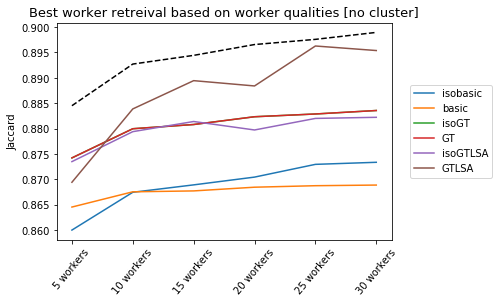

In [1000]:
plt.plot(best_isobasic_score,label="isobasic")
plt.plot(best_basic_score,label="basic")
plt.plot(best_GT_score,label="isoGT")
plt.plot(best_isoGT_score,label="GT")
plt.plot(best_GTLSA_score,label="isoGTLSA")
plt.plot(best_isoGTLSA_score,label="GTLSA")
x,algo_noclust,algo_clust=clust_vs_noclust("MV",filtered=False)
plt.plot(algo_clust,linestyle="--",color = "black")
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Best worker retreival based on worker qualities [no cluster]",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])

Best cluster

In [1021]:
qj_df["sample_num"] = qj_df.apply(lambda x: int(x["sample"].split("rand")[-1]),axis=1)
# qj_df_clust = filter_best_clust(qj_df,best_clust_df)
# qj_df_clust.groupby(["sample","objid","clust"]).count()

In [1073]:
def best_cluster(x):
    try:
        return obj_clusters[x["sample"]][str(x["objid"])]
    except(KeyError):
        return -1

qj_df["best_clust"]=qj_df.apply(lambda x: best_cluster(x),axis=1)
qj_df_clust = qj_df[qj_df["best_clust"]==qj_df["clust"]]

In [1091]:
assert len(qj_df_clust.groupby(["sample","objid"],as_index=False).mean()[["sample","objid"]])==31*46

In [1101]:
# len(isoGTLSA_predicted_clust[isoGTLSA_predicted_clust["objid"]==31])

In [1092]:
x_fields = ['qp1', 'qn1', 'qp2', 'qn2']
best_GTLSA_score_clust,GTLSA_predicted_clust = predict_prj_linear_regression(qj_df_clust,x_fields)

x_fields = ['iqp1', 'iqn1', 'iqp2', 'iqn2']
best_isoGTLSA_score_clust,isoGTLSA_predicted_clust = predict_prj_linear_regression(qj_df_clust,x_fields)

x_fields = ['qp', 'qn']
best_GT_score_clust,GT_predicted_clust = predict_prj_linear_regression(qj_df_clust,x_fields)

x_fields = ['iqp', 'iqn']
best_isoGT_score_clust,isoGT_predicted_clust = predict_prj_linear_regression(qj_df_clust,x_fields)

x_fields = ['iqj']
best_isobasic_score_clust,isobasic_predicted_clust = predict_prj_linear_regression(qj_df_clust,x_fields)

x_fields = ['qj']
best_basic_score_clust,basic_predicted_clust = predict_prj_linear_regression(qj_df_clust,x_fields)

  0%|          | 0/31 [00:00<?, ?it/s]         

assertion error: 1411


  0%|          | 0/31 [00:00<?, ?it/s]         

assertion error: 1411


  0%|          | 0/31 [00:00<?, ?it/s]         

assertion error: 1411


  0%|          | 0/31 [00:00<?, ?it/s]         

assertion error: 1411


  0%|          | 0/31 [00:00<?, ?it/s]         

assertion error: 1411


assertion error: 1411


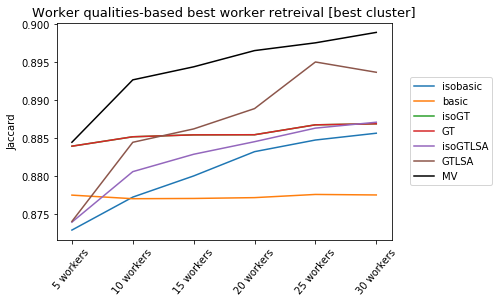

In [1110]:
plt.plot(best_isobasic_score_clust,label="isobasic")
plt.plot(best_basic_score_clust,label="basic")
plt.plot(best_GT_score_clust,label="isoGT")
plt.plot(best_isoGT_score_clust,label="GT")
plt.plot(best_GTLSA_score_clust,label="isoGTLSA")
plt.plot(best_isoGTLSA_score_clust,label="GTLSA")
x,algo_noclust,algo_clust=clust_vs_noclust("MV",filtered=False)
plt.plot(algo_clust,color = "black",label="MV")
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Worker qualities-based best worker retreival [best cluster]",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])

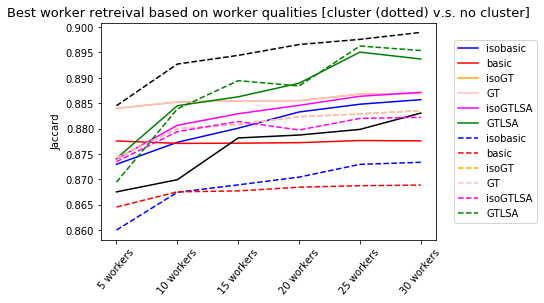

In [1107]:
plt.plot(best_isobasic_score_clust,label="isobasic",color="blue")
plt.plot(best_basic_score_clust,label="basic",color="red")
plt.plot(best_GT_score_clust,label="isoGT",color="orange")
plt.plot(best_isoGT_score_clust,label="GT",color="pink")
plt.plot(best_GTLSA_score_clust,label="isoGTLSA",color="magenta")
plt.plot(best_isoGTLSA_score_clust,label="GTLSA",color="green")
x,algo_noclust,algo_clust=clust_vs_noclust("MV",filtered=False)
plt.plot(algo_noclust,linestyle="-",color = "black")
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Best worker retreival based on worker qualities [best cluster]",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])

plt.plot(best_isobasic_score,label="isobasic",linestyle="--",color="blue")
plt.plot(best_basic_score,label="basic",linestyle="--",color="red")
plt.plot(best_GT_score,label="isoGT",linestyle="--",color="orange")
plt.plot(best_isoGT_score,label="GT",linestyle="--",color="pink")
plt.plot(best_GTLSA_score,label="isoGTLSA",linestyle="--",color="magenta")
plt.plot(best_isoGTLSA_score,label="GTLSA",linestyle="--",color="green")
x,algo_noclust,algo_clust=clust_vs_noclust("MV",filtered=False)
plt.plot(algo_clust,linestyle="--",color = "black")
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Best worker retreival based on worker qualities [cluster  v.s. no cluster(dotted)]",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])

- show just the clustered case here